README: 
- based on set_manual_treshold_v5.1.ipynb
- build 10 models for each class
- continue to work on multi-class classification, using Multinomial NB()
- TODO: try different models + add cross validation for hyperparameter tuning

In [1]:
import pandas as pd
import os
os.chdir('/Users/liyuan/desktop/CSAir/codes')
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from modeling_main import ReviewClassify
from tokenization import Tokenization
from help import get_tokenized_sent, get_stopwords

from prepare_data import PrepareData
from modeling import Modeling

import keras
from keras.utils import to_categorical
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 

Using TensorFlow backend.


In [2]:
def predict_label(model,X_train,y_train):
    ''' predict label for each review, by picking the class with highest probability'''
    multi_class_clf = OneVsRestClassifier(model, n_jobs=-1)
    multi_class_clf.fit(X_train, y_train)
    # each review has proba for 10 classes
    scores = multi_class_clf.predict_proba(X_test)
    return scores

def get_class_label_name(scores,idx):
    ''' input a review index, and get the predicted label 
    (the one with highest probability) for this review'''
    label_encoded = np.argmax(scores[idx])
    return [key for key in labels_index if labels_index[key] ==label_encoded ].pop()

def add_pred_to_df(scores, df):
    '''add predicted labels to original df'''
    predicted_labels = []
    for i in range(len(scores)):
        label_pred = get_class_label_name(scores,i)
        predicted_labels.append(label_pred)
    # add predicted labels to original test df
    df['pred_label'] = predicted_labels
    return df

def get_confusion_matrix(y_test,y_pred):
    '''get confusion matrix (tp,tn,fp,fn) for each class'''
    cm = ConfusionMatrix(y_test, y_pred)
    cm.print_stats()

In [3]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    # updated: drop na values
    data = data.dropna()
    return data

def split_data(data):
    train, test = train_test_split(data, test_size = 0.33, random_state=42)
#     print('training data has %d examples' %len(train))
#     print('test data has %d examples' %len(test))
    return train, test

def preprocess_data(data, train, test):
    '''use countvectorizer and tf-idf transformer to get valid one-hot encoding for reviews'''
    # use countVectorizer for one-hot encoding
    count_v0= CountVectorizer()
    counts_all = count_v0.fit_transform(data['review_tokens'])
    count_v1= CountVectorizer(vocabulary=count_v0.vocabulary_)  
    counts_train = count_v1.fit_transform(train.review_tokens)

    count_v2 = CountVectorizer(vocabulary=count_v0.vocabulary_)
    counts_test = count_v2.fit_transform(test.review_tokens)

    # implement tf-idf
    tfidftransformer = TfidfTransformer()
    train_data = tfidftransformer.fit(counts_train).transform(counts_train)
    test_data = tfidftransformer.fit(counts_test).transform(counts_test)

    X_train = train_data
    # y_train = train.label_encoded
    y_train = train.label_or_not.values
    X_test = test_data
    # y_test = test.label_encoded
    y_test = test.label_or_not.values
    return X_train, y_train, X_test, y_test

# multi-class modeling
def multi_class_preprocess(data,label):
    '''data preprocess for multi-class'''
    data.loc[data.label == label, 'label_or_not'] = 1
    data.loc[data.label != label, 'label_or_not'] = 0
    return data

def get_class_prior(data, label):
    '''get class prior
    class_prior = class_size / data_size'''
    class_prior = len(data[data['label']== label]) / len(data)
    return class_prior

def get_class_threshold(class_prob, class_prior):
    '''use class_priors are percentile for each class label '''
    # there are 10 class in total
    # col = 1 represent 'positive'
    # first index represents the class, e.g., prob_scores[0][:,1] -> prob. when labeled as class 0 for each review
    # class_prob = prob_scores[:,1] 
    # get the higher bound percentile
    percentile = (1 - class_prior)*100
    threshold = np.percentile(class_prob, percentile) 
    return threshold

def get_label(idx, labels, positive_review_dct):
    '''input an index and output a list of predicted labels'''
    label_pred = []
    for label in labels:
        if idx in positive_review_dct[label]:
            label_pred.append(label)
    return label_pred

def get_prob(data, model,label):
    '''get probability predicted for one label class'''
    label_data = multi_class_preprocess(data,label)
    # split data
    train, test = split_data(label_data)
    # vectorize reviews
    X_train, y_train, X_test, y_test = preprocess_data(label_data, train, test)
    # modeling
    model.fit(X_train,y_train)
    # get the proba score for one class
    class_prob = model.predict_proba(X_test)[:,1] 
    # e.g., class_proba: [0.15,0.3,...] => 512 records in total
    class_prob_values = class_prob.reshape(-1,1)
    return class_prob_values

def manual_classify(data, label, class_prob):
    '''classify by setting manual threshold of probability (for one class)'''
    # get class_prior
    class_prior = get_class_prior(data, label)
    # set manual threshol
    threshold = get_class_threshold(class_prob, class_prior)
    class_labels = []
    proba_dct = {}
    for score in class_prob:
        if score > threshold:
            label = 1
        else:
            label = 0
        class_labels.append(label)
    positive_reviews = [ idx for idx in range(len(class_labels)) if class_labels[idx] == 1  ]
    return positive_reviews

# get label_picked for review with multiple labels predicted
def pick_label(review_idx):
    '''compare proba of each label_pred, and pick the one with higher proba'''
    # get label_idx
    label_idx_dct = {}
    for idx,label in enumerate(labels):
        label_idx_dct[label] = idx
  
    # pick label
    label_proba_dct = {}
    for i,label_pred in enumerate(test_label_pred[review_idx]):
        label_index = label_idx_dct.get(label_pred)
        label_proba_dct[label_pred] = prob_matrix[review_idx,label_index]
    label_picked = [key for key in label_proba_dct if label_proba_dct[key] == max(label_proba_dct.values())]
    return label_picked

In [4]:
data = load_data('../res/labeled_data_with_without_tk.csv')
# train, test data that include all label classes
train, test = split_data(data)

class_prob_values_dct = {}
labels = data.label.unique().tolist()
print(labels)

for label in labels:
    model = LogisticRegression()
    # model = MultinomialNB()
    
    class_prob_values = get_prob(data, model,label)
    class_prob_values_dct[label] = class_prob_values
prob_matrix = np.hstack((list(class_prob_values_dct.values())))
prob_matrix

# get a dictionary: {0:[0.13,0.25,...], 1:[..], 2:[..],.. 511:[..]} that list the probability 
# of each user review across all 10 classes (each list within the values of the dictionary has 10 proba values)

['计划', '机上', '中转', '售后', '预订', '设计', '出发', '性能', '行程', '到达']


array([[0.00582957, 0.05858162, 0.04230719, ..., 0.01429871, 0.00719745,
        0.04291633],
       [0.02177721, 0.70625199, 0.0837076 , ..., 0.04998957, 0.03035963,
        0.12514783],
       [0.00270801, 0.03369999, 0.04884033, ..., 0.01254567, 0.00615541,
        0.010975  ],
       ...,
       [0.00337757, 0.09572706, 0.01707567, ..., 0.01850019, 0.00693434,
        0.01020521],
       [0.00179967, 0.02107788, 0.00737943, ..., 0.00544953, 0.00414087,
        0.00513647],
       [0.00227813, 0.09816865, 0.03402016, ..., 0.00829194, 0.00417031,
        0.02997548]])

In [ ]:
# TODO: cross validation
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
parameters = {'penalty':('l2', 'l1'), 'C':[0.01,0.1,1,10]}
clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

proba redicted for review 0:
[0.00582957 0.05858162 0.04230719 0.0243446  0.02265558 0.00491237
 0.32661221 0.01429871 0.00719745 0.04291633]
----
proba predicted for review 0 and class 0:
0.005829567783155731


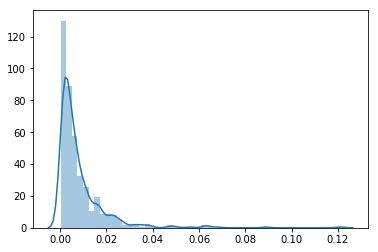

In [5]:
# checking
print('proba redicted for review 0:')
print(prob_matrix[0])
print('----')
print('proba predicted for review 0 and class 0:')
print(prob_matrix[0,0])

# distribution plor for class 0 
sns.distplot(prob_matrix[:,0])
plt.show()

In [6]:
# add prediction results into a dictionary
positive_review_dct = {}
for i,label in enumerate(labels):
    positive_reviews = manual_classify(data, label, prob_matrix[:,i])
    positive_review_dct[label] = positive_reviews
print('review indices predicted as positive in class 计划:',positive_review_dct['计划'])

review indices predicted as positive in class 计划: [34, 90, 98, 100, 144, 176, 232, 290, 384, 389, 399, 417, 426]


In [7]:
# get reversed dictionary: key is the index of user review, value is the labels predicted
test_label_pred = {}
for idx in range(len(test)):
    label_pred = get_label(idx,labels,positive_review_dct)
    test_label_pred[idx] = label_pred

In [8]:
for i in range(len(test)):
    # handle review with multiple labels
    if len(test_label_pred[i]) > 1: 
        label_picked = pick_label(i)
        test_label_pred[i] = label_picked
        
# reput prediction into original dataframe
test_ = test.copy()
test_['predicted_labels'] = list(test_label_pred.values())
test_.head()

,review,review_tokens,label,label_encoded,predicted_labels
1520,行李箱丢了！在荷兰机场语言不通，你们航空公司也没个人来管事，解释！,行李箱 丢 荷兰 机场 语言不通 航空公司 管事 解释,到达,2,[出发]
1442,昨晚（11月11日）我搭乘cz8278次18:25长沙飞海口的航班，飞机下降临近海口时，我突...,昨晚 月 日 搭乘 次 长沙 飞 海口 航班 飞机 下降 临近 海口 时 突发 眩晕 症 四...,到达,2,[机上]
351,延误能不能早点通知，我就好修改航班，下午16点到机场，延误就早点通知，我就能修改18点的航班...,延误 早点 通知 修改 航班 下午 点到 机场 延误 早点 通知 修改 点 航班 延误 晚上...,中转,0,[出发]
352,严重晚点,晚点,中转,0,[出发]
578,我在网上补登里程、只能䃼登上9月24日南京-广州、国际段䃼登不上、麻烦处理一下。 zhu n...,网上 补登 里程 只能 登上 月 日 南京 广州 国际 段 登不上 麻烦 朱宁生 月 日 票...,售后,3,[]


In [9]:
def formatting(row):
    '''remove [] in the prediction result'''
    if len(row) > 0:
        return row[0]
    else:
        # np.nan is float, not supported for confusion matrix calculation, so change it to 'N/A'
        return 'N/A'

test_['predicted_labels'] = test_['predicted_labels'].apply(formatting)
test_.head()

,review,review_tokens,label,label_encoded,predicted_labels
1520,行李箱丢了！在荷兰机场语言不通，你们航空公司也没个人来管事，解释！,行李箱 丢 荷兰 机场 语言不通 航空公司 管事 解释,到达,2,出发
1442,昨晚（11月11日）我搭乘cz8278次18:25长沙飞海口的航班，飞机下降临近海口时，我突...,昨晚 月 日 搭乘 次 长沙 飞 海口 航班 飞机 下降 临近 海口 时 突发 眩晕 症 四...,到达,2,机上
351,延误能不能早点通知，我就好修改航班，下午16点到机场，延误就早点通知，我就能修改18点的航班...,延误 早点 通知 修改 航班 下午 点到 机场 延误 早点 通知 修改 点 航班 延误 晚上...,中转,0,出发
352,严重晚点,晚点,中转,0,出发
578,我在网上补登里程、只能䃼登上9月24日南京-广州、国际段䃼登不上、麻烦处理一下。 zhu n...,网上 补登 里程 只能 登上 月 日 南京 广州 国际 段 登不上 麻烦 朱宁生 月 日 票...,售后,3,N/A


In [10]:
# get confusion matrix
get_confusion_matrix(test_.label,test_.predicted_labels)

Confusion Matrix:

Predicted  N/A  中转   出发  到达  售后  性能  机上  行程  计划  设计  预订  __all__
Actual                                                          
N/A          0   0    0   0   0   0   0   0   0   0   0        0
中转          30   9   11   1   0   0   2   0   0   0   1       54
出发          38   3   54   8   4   1   3   1   0   0   0      112
到达          18   0    8  15   0   0   6   0   0   0   0       47
售后          23   0    6   0  17   0   0   0   0   0   2       48
性能          21   0    3   0   1  13   3   1   0   0  13       55
机上          18   1   13   1   0   0  60   0   0   0   0       93
行程          10   0    2   0   1   0   0   3   0   0   2       18
计划           2   0    0   0   0   1   0   0   2   0   2        7
设计           4   0    0   0   0   4   1   0   0   1   2       12
预订          22   0    4   0   1   3   1   0   0   0  35       66
__all__    186  13  101  25  24  22  76   5   2   1  57      512


Overall Statistics:

Accuracy: 0.408203125
95% CI: (0.365290355505708

In [ ]:
# 由于有NA value存在（意为有些reviews完全没有被任何class选中为positive), 
# 导致performance相比较logistic regression的0.5 theshold, 还是差一些